In [1]:
%pip install -e ..

Obtaining file:///C:/Users/frolo/Documentos/PythonProjects/forecast-models
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for forecast-models (pyproject.toml): started
  Building editable for forecast-models (pyproject.toml): finished with status 'done'
  Created wheel for forecast-models: filename=forecast_models-0.1.0-0.editable-py3-none-any.whl size=2044 sha256=78abe97fe9a6f6db8c3b69a731f0f040f9718e916277d266a35e85c59e89c044
  Stored in directory: C:\Users\frolo\AppData\Local\Temp\pip-ephem-wheel-cache-v2nd0xaw\wheels\0b\9


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\frolo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
# Import required packages
import os, sys, json, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# add repo root and /src to the path (so local edits are picked up)
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../src"))

# core package bits
from forecast_models.data.loaders import load_timeseries
from forecast_models.data.transforms import (
    choose_transform_auto,
    StationarityTransform,
)
from forecast_models.models.arima import AutoARIMA, AutoARIMAConfig, ARIMA, ARIMAConfig

# save/load helpers (with fallback to joblib if module not present)
try:
    from forecast_models.models.io import save_model, load_model   # if you added io.py
except Exception as _:
    import joblib
    def save_model(obj, path): joblib.dump(obj, path, compress=3, protocol=5)
    def load_model(path): return joblib.load(path)

print("imports ok")


imports ok


In [2]:
# load timeseries and select subset
DATA_PATH = "entsoe_day_ahead_price_10YES-REE------0.parquet"

df = load_timeseries(
    DATA_PATH,
    time_col="timestamp_utc",  
    value_col="value",
)

N_DAYS = 120  
df = df.tail(N_DAYS * 24).reset_index(drop=True)
display(df.head())
print(df.shape, df["ds"].min(), df["ds"].max())


,ds,y
0,2025-04-20 03:00:00+00:00,3.52
1,2025-04-20 05:00:00+00:00,7.00
2,2025-04-20 06:00:00+00:00,3.52
3,2025-04-20 07:00:00+00:00,1.60
4,2025-04-20 08:00:00+00:00,0.00


(2880, 2) 2025-04-20 03:00:00+00:00 2025-08-26 21:00:00+00:00


In [3]:
# configurations and training
# --- choose + fit a transform (auto; prefers diff)
tf = choose_transform_auto(df["y"], prefer="diff")
y_train_trans = tf.transform(df["y"]) if tf.kind != "none" else df["y"]

# --- model config (AutoARIMA is a strong default for hourly data)
M = 24  # daily seasonality for hourly series
cfg = AutoARIMAConfig(
    seasonal=True, m=M,
    d=0, D=0,
    max_p=2, max_q=2, 
    max_P=1, max_Q=1, 
    max_order=4,
    test="adf", seasonal_test="ocsb",
    information_criterion="aic",
    use_boxcox=False,
    stepwise=True, trace=False,
    suppress_warnings=True, error_action="ignore",
)

model = AutoARIMA(cfg)
model.fit(y_train_trans.values)

# --- package: store model + transform (+ a little metadata for convenience)
PKL_PATH = "autoarima_dayahead.pkl"
package = {
    "model_name": "auto_arima",
    "model_cfg": cfg.__dict__,
    "transform_kind": tf.kind,
    "transform": tf,     # needed for inverse()
    "model": model,
    "meta": {"m": M, "history_rows": int(len(df))}
}
save_model(package, PKL_PATH)
print(f"✅ trained and saved -> {PKL_PATH}")


C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

✅ trained and saved -> autoarima_dayahead.pkl


In [4]:
# %%
H = 24  # forecast horizon (hours)
loaded = load_model(PKL_PATH)
model = loaded["model"]
tf = loaded["transform"]

# predict on transformed scale
preds_trans = np.asarray(model.predict(H), dtype=float)

# invert to original scale using the original-history series
preds = tf.inverse(pd.Series(preds_trans), df["y"]).reset_index(drop=True)

# build future timestamps right after last observed point
freq = pd.infer_freq(df["ds"])
if freq is None:
    # conservative fallback: use the most common delta
    deltas = pd.Series(df["ds"]).diff().dropna()
    freq = deltas.mode().iat[0] if len(deltas) else "H"

future_index = pd.date_range(
    start=df["ds"].iloc[-1] + pd.tseries.frequencies.to_offset(freq),
    periods=H,
    freq=freq,
    tz="UTC",
)

pred_df = pd.DataFrame({"ds": future_index, "yhat": preds})
display(pred_df.head())


C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,ds,yhat
0,2025-08-26 22:00:00+00:00,98.455575
1,2025-08-26 23:00:00+00:00,92.016673
2,2025-08-27 00:00:00+00:00,86.061469
3,2025-08-27 01:00:00+00:00,81.470728
4,2025-08-27 02:00:00+00:00,78.004144


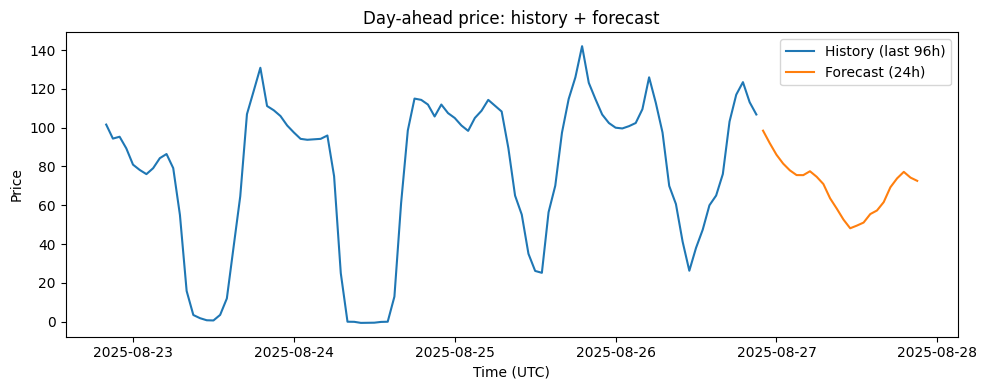

History:  2025-08-22 20:00:00+00:00 → 2025-08-26 21:00:00+00:00
Forecast: 2025-08-26 22:00:00+00:00 → 2025-08-27 21:00:00+00:00
First 5 preds: [{'ds': Timestamp('2025-08-26 22:00:00+0000', tz='UTC'), 'yhat': 98.45557507591397}, {'ds': Timestamp('2025-08-26 23:00:00+0000', tz='UTC'), 'yhat': 92.01667257332612}, {'ds': Timestamp('2025-08-27 00:00:00+0000', tz='UTC'), 'yhat': 86.06146932020462}, {'ds': Timestamp('2025-08-27 01:00:00+0000', tz='UTC'), 'yhat': 81.47072790524196}, {'ds': Timestamp('2025-08-27 02:00:00+0000', tz='UTC'), 'yhat': 78.00414417669616}]


In [5]:
# %%
hist_tail = df.tail(96)

plt.figure(figsize=(10, 4))
plt.plot(hist_tail["ds"], hist_tail["y"], label="History (last 96h)")
plt.plot(pred_df["ds"], pred_df["yhat"], label=f"Forecast ({H}h)")
plt.title("Day-ahead price: history + forecast")
plt.xlabel("Time (UTC)")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

print(f"History:  {hist_tail['ds'].iloc[0]} → {hist_tail['ds'].iloc[-1]}")
print(f"Forecast: {pred_df['ds'].iloc[0]} → {pred_df['ds'].iloc[-1]}")
print("First 5 preds:", pred_df.head().to_dict(orient="records"))


In [ ]:
# %%
def mae(y_true, y_pred):
    a = pd.Series(y_true, dtype="float64").to_numpy()
    b = pd.Series(y_pred, dtype="float64").to_numpy()
    return float(np.mean(np.abs(a - b)))

def rmse(y_true, y_pred):
    a = pd.Series(y_true, dtype="float64").to_numpy()
    b = pd.Series(y_pred, dtype="float64").to_numpy()
    return float(np.sqrt(np.mean((a - b)**2)))

def mape(y_true, y_pred, eps=1e-12):
    a = pd.Series(y_true, dtype="float64").to_numpy()
    b = pd.Series(y_pred, dtype="float64").to_numpy()
    return float(np.mean(np.abs((a - b) / np.maximum(np.abs(a), eps)))) * 100.0

H_TEST = 24 * 7  # one-week holdout

# split in original scale
y_all = df["y"].astype(float)
y_tr_orig, y_te_orig = y_all.iloc[:-H_TEST], y_all.iloc[-H_TEST:]

# fit a fresh transform on the training history
tf_bt = choose_transform_auto(y_tr_orig, prefer="logdiff")
y_tr_trans = tf_bt.transform(y_tr_orig) if tf_bt.kind != "none" else y_tr_orig

# re-train a fresh model for the backtest (same config)
bt_model = AutoARIMA(cfg)
bt_model.fit(y_tr_trans.values)

# predict H_TEST on transformed scale and invert with the *training* history
preds_bt_trans = np.asarray(bt_model.predict(H_TEST), dtype=float)
preds_bt = tf_bt.inverse(pd.Series(preds_bt_trans), y_tr_orig).reset_index(drop=True)

scores = {
    "horizon": H_TEST,
    "mae": mae(y_te_orig.values, preds_bt.values),
    "rmse": rmse(y_te_orig.values, preds_bt.values),
    "mape": mape(y_te_orig.values, preds_bt.values),
}
print(json.dumps(scores, indent=2))
